In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
from sklearn.metrics import mean_squared_error

In [2]:
color_pal = sns.color_palette()

In [3]:
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

# Read dataset and set index column

In [4]:
df = pd.read_csv('../datasets/hourlyenergydata/PJMW_hourly.csv')
df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143206 entries, 0 to 143205
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  143206 non-null  object 
 1   PJMW_MW   143206 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [6]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143206 entries, 0 to 143205
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  143206 non-null  datetime64[ns]
 1   PJMW_MW   143206 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB


In [7]:
# set datetime column as index column
df = df.set_index('Datetime')

## Plot the data

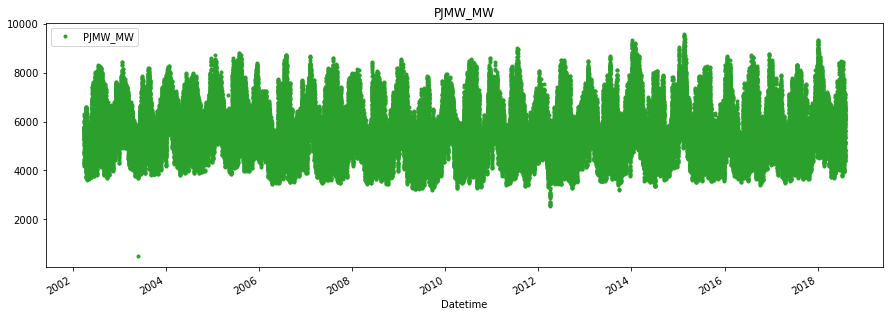

In [8]:
df.plot(style='.',figsize = (15,5), color = color_pal[2], title = 'PJMW_MW')
plt.show()

## Train/Test split

In [9]:
train = df.loc[df.index<'10-10-2015']
test = df.loc[df.index>'10-10-2015']
train

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077.0
2002-12-31 02:00:00,4939.0
2002-12-31 03:00:00,4885.0
2002-12-31 04:00:00,4857.0
2002-12-31 05:00:00,4930.0
...,...
2015-01-01 20:00:00,6461.0
2015-01-01 21:00:00,6393.0
2015-01-01 22:00:00,6234.0


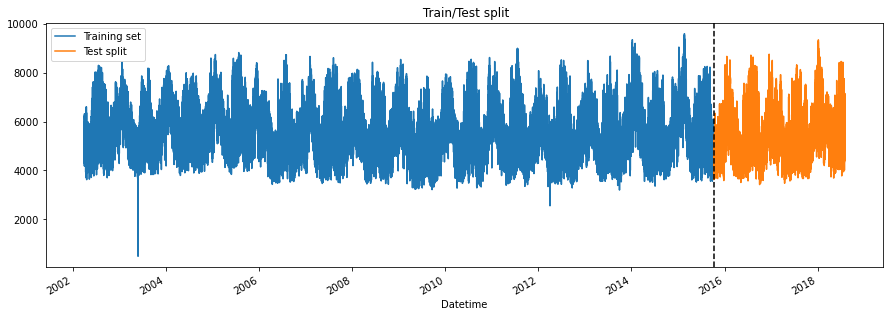

In [10]:
#plot test and training data
fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax=ax, label = 'Training data',title = " Train/Test split")
test.plot(ax=ax, label = 'Test data')
ax.axvline('10-10-2015', color = 'black', ls = '--') #draw black line separating the two datasets
ax.legend(['Training set', 'Test split'])
plt.show()

In [11]:
def createFeatures(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['minutes'] = df.index.minute
    df['dayofweek'] = df.index.day_of_week
    df ['month'] = df.index.month
    df['week'] = df.index.week
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year

    return df

<AxesSubplot:xlabel='Datetime'>

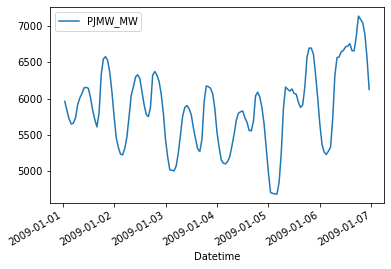

In [12]:
df.loc[(df.index>'01-01-2009') & (df.index<'01-07-2009')].plot(style = '-')

# Visualize our feature/target relationship

In [13]:
df = createFeatures(df)

/tmp/ipykernel_672/3939475721.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = df.index.week


In [14]:
df.head()

,PJMW_MW,hour,minutes,dayofweek,month,week,quarter,year
Datetime,,,,,,,,
2002-12-31 01:00:00,5077.0,1,0,1,12,1,4,2002
2002-12-31 02:00:00,4939.0,2,0,1,12,1,4,2002
2002-12-31 03:00:00,4885.0,3,0,1,12,1,4,2002
2002-12-31 04:00:00,4857.0,4,0,1,12,1,4,2002
2002-12-31 05:00:00,4930.0,5,0,1,12,1,4,2002


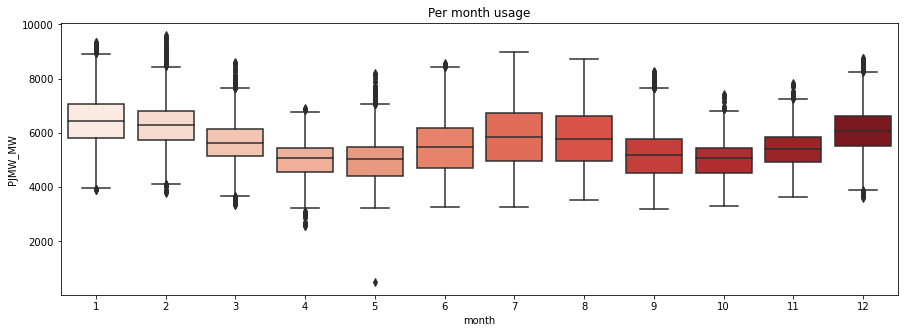

In [15]:
fig, ax = plt.subplots(figsize = (15,5))
sns.boxplot(data = df, x = 'month', y = 'PJMW_MW', palette = 'Reds')
ax.set_title("Per month usage")
plt.show()

# Model

In [16]:
train = createFeatures(train)
test = createFeatures(test)

/tmp/ipykernel_672/3939475721.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = df.index.week
/tmp/ipykernel_672/3939475721.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = df.index.week


In [17]:
columns = train.columns
target = columns[0:1]
features = columns[1:]

In [18]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118533 entries, 2002-12-31 01:00:00 to 2015-01-02 00:00:00
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   hour       118533 non-null  int64
 1   minutes    118533 non-null  int64
 2   dayofweek  118533 non-null  int64
 3   month      118533 non-null  int64
 4   week       118533 non-null  int64
 5   quarter    118533 non-null  int64
 6   year       118533 non-null  int64
dtypes: int64(7)
memory usage: 7.2 MB


In [20]:
reg = xgboost.XGBRegressor(n_estimators = 500,
                           early_stopping = 50,
                           learning_rate = 0.01)
reg.fit(
    X_train,y_train,
    eval_set = [(X_train,y_train),(X_test,y_test)],
    verbose = 100
)

[22:34:31] WARNING: ../src/learner.cc:627: 
Parameters: { "early_stopping" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:5637.01689	validation_1-rmse:5598.06738
[100]	validation_0-rmse:2128.27159	validation_1-rmse:2068.03827
[200]	validation_0-rmse:910.61978	validation_1-rmse:947.30348
[300]	validation_0-rmse:554.13543	validation_1-rmse:720.01394
[400]	validation_0-rmse:464.86724	validation_1-rmse:711.32183
[499]	validation_0-rmse:436.15911	validation_1-rmse:728.14239


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping=50, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, ...)

## MLFlow

### 1. Run and track with MLFlow
**mlflow server --backend-store-uri sqlite:///mflow.db --default-artifact-root mlruns/ --host 0.0.0.0 --port 5000** for local

**mlflow server --backend-store-uri sqlite:///mflow.db --default-artifact-root s3:/bucket_name --host 0.0.0.0 --port 5000** for string artifact in s3 bucket



In [28]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.metrics import mean_squared_error
import numpy as np

In [29]:
server_ui = "http://0.0.0.0:5000"
mlflow.set_tracking_uri(server_ui)  #set mlflow tracking

#### create a new experiment

In [31]:
# you can do this through gui as well
exp_name = "load_estimation"
mlflow.create_experiment(exp_name)

#### Add tracking to ML model above:
1. parameters:key-value, mlflow.log_param, mlflow.log_parms
2. metrics:key-value metrics mlflow.log_metric,mlflow.log_metrics

In [32]:
mlflow.set_experiment(exp_name)  #set the name of the experiment we want to track
with mlflow.start_run() as run:
    print(f"Started run {run.info.run_id}")
    n_estimaor = 500
    learning_rate = 0.01
    early_stopping = 50
    mlflow.log_params(
        {
            "n_estimators" : n_estimaor,
            "lr" :learning_rate,
            "early_stopping":early_stopping
        }
    )
    reg = xgboost.XGBRegressor(n_estimators = 500,
                           early_stopping = 50,
                           learning_rate = 0.01)
    reg.fit(
    X_train,y_train,
    eval_set = [(X_train,y_train),(X_test,y_test)],
    verbose = 100
    )
    # calculate test scores
    test_score = mean_squared_error(y_test,reg.predict(X_test))
    test_score = np.sqrt(test_score)
    mlflow.log_metric("rmse",test_score)
    print("rmse:{}".format(test_score))

Started run 3b30743d6b35499b92598198f93b2140
[23:35:50] WARNING: ../src/learner.cc:627: 
Parameters: { "early_stopping" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:5637.01689	validation_1-rmse:5598.06738
[100]	validation_0-rmse:2128.27159	validation_1-rmse:2068.03827
[200]	validation_0-rmse:910.61978	validation_1-rmse:947.30348
[300]	validation_0-rmse:554.13543	validation_1-rmse:720.01394
[400]	validation_0-rmse:464.86724	validation_1-rmse:711.32183
[499]	validation_0-rmse:436.15911	validation_1-rmse:728.14239
rmse:728.1423936628917


#### We can track additional stuff as well
- code version: git commit has used for the run
- start and end time
- plots
- model artifacts
- properties of input data: model.log_param("number of features", data.shape[1])
- complete notebook: model.log_artifact("path to ipynb notebook")

In [36]:
# same as previous cell with model artifact and number of features
mlflow.set_experiment(exp_name)  #set the name of the experiment we want to track
with mlflow.start_run() as run:
    print(f"Started run {run.info.run_id}")
    n_estimaor = 400
    learning_rate = 0.01
    early_stopping = 50
    mlflow.log_params(
        {
            "n_estimators" : n_estimaor,
            "lr" :learning_rate,
            "early_stopping":early_stopping
        }
    )
    mlflow.log_param("#features", X_train.shape[1]) #number of features log
    reg = xgboost.XGBRegressor(n_estimators = 500,
                               early_stopping = 50,
                               learning_rate = 0.01
    )
    reg.fit(
            X_train,y_train,
            eval_set = [(X_train,y_train),(X_test,y_test)],
            verbose = 100
    )
    # calculate test scores
    test_score = mean_squared_error(y_test,reg.predict(X_test))
    test_score = np.sqrt(test_score)
    mlflow.log_metric("rmse",test_score)
    mlflow.log_artifact("mlflowtutorial.ipynb")
    print("rmse:{}".format(test_score))

Started run 2fbbdb4899eb4262a620864effe1808d
[09:51:07] WARNING: ../src/learner.cc:627: 
Parameters: { "early_stopping" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:5637.01689	validation_1-rmse:5598.06738
[100]	validation_0-rmse:2128.27159	validation_1-rmse:2068.03827
[200]	validation_0-rmse:910.61978	validation_1-rmse:947.30348
[300]	validation_0-rmse:554.13543	validation_1-rmse:720.01394
[400]	validation_0-rmse:464.86724	validation_1-rmse:711.32183
[499]	validation_0-rmse:436.15911	validation_1-rmse:728.14239
rmse:728.1423936628917


#### Log the model (ML flow)
mlflow.sklearn.log_model(tree, "model")

In [49]:
# same code as above with log model functionality
mlflow.set_experiment(exp_name)  #set the name of the experiment we want to track
with mlflow.start_run() as run:
    print(f"Started run {run.info.run_id}")
    n_estimaor = 400
    learning_rate = 0.01
    early_stopping = 50
    mlflow.log_params(
        {
            "n_estimators" : n_estimaor,
            "lr" :learning_rate,
            "early_stopping":early_stopping
        }
    )
    mlflow.log_param("#features", X_train.shape[1]) #number of features log
    reg = xgboost.XGBRegressor(n_estimators = 500,
                               early_stopping = 50,
                               learning_rate = 0.01
    )
    reg.fit(
            X_train,y_train,
            eval_set = [(X_train,y_train),(X_test,y_test)],
            verbose = 100
    )
    # calculate test scores
    test_score = mean_squared_error(y_test,reg.predict(X_test))
    test_score = np.sqrt(test_score)
    mlflow.log_metric("rmse",test_score)
    mlflow.log_artifact("mlflowtutorial.ipynb")
    mlflow.xgboost.log_model(reg,"model")
    print("rmse:{}".format(test_score))

Started run e08bfc49db6540e191c1169810e22f96
[15:56:12] WARNING: ../src/learner.cc:627: 
Parameters: { "early_stopping" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:5637.01689	validation_1-rmse:5598.06738
[100]	validation_0-rmse:2128.27159	validation_1-rmse:2068.03827
[200]	validation_0-rmse:910.61978	validation_1-rmse:947.30348
[300]	validation_0-rmse:554.13543	validation_1-rmse:720.01394
[400]	validation_0-rmse:464.86724	validation_1-rmse:711.32183
[499]	validation_0-rmse:436.15911	validation_1-rmse:728.14239
rmse:728.1423936628917


#### How to use the saved model
![loggedmodel](mlflowmodelpredict.png)


In [42]:
loadmodel = 'runs:/2a232701bdc84cd4b79e0ac0fafd54d4/xgboostregressor' #path mentioned in artifact 
model = mlflow.pyfunc.load_model(loadmodel)
model.predict(X_test)

array([5177.0234, 5095.1104, 5053.589 , ..., 6706.567 , 6463.906 ,
       6272.7134], dtype=float32)

#### Add a signature to a model

### 2. Deploy and Manage

#### 2.1 MLFlow Models:
 is a standard format for packaging machine learning models that be used in a variety of downstream tools, e.g. real-time serving through a REST API or batch inference on Apache Spark. The format define a convention that lets you save model in different flavours that can be understood by different downstream tools.

For environment recreation, we can use conda.yml or requirements.txt files. 

#### The MLFlow Model Registry:

this component is a centrailized model store, set of APIs and UI to collaboratively manage the full lifecycle of an MLFlow Model. It provides model lineage (which MLFlow experiement produced the model), model versioning and stage transition.

#### 2.3 Register a model:
For this first we need to have the model

In [43]:
#we need to set tracking uri which we already did in the previous section
# remote_server_uri = 'http://0.0.0.0:5000'
# mlflow.set_tracking_uri(remote_server_uri)

In [45]:
# Step 1: create registered model
from mlflow.tracking import MlflowClient
from mlflow.exceptions import RestException

model_name = "load_estimator"
client = MlflowClient()
try:
    registered_model = client.create_registered_model(model_name)
    print(registered_model)
except RestException:
    print("Model{}".format(model_name))

<RegisteredModel: creation_timestamp=1658666785125, description='', last_updated_timestamp=1658666785125, latest_versions=[], name='load_estimator', tags={}>


In [50]:
# Step 2: Resiter experiment runs to that model. Pick a run id from your tracking log.
# Click any model and on the next page you will find runid
run_id = 'e08bfc49db6540e191c1169810e22f96'
result = mlflow.register_model(
    f"runs:/{run_id}/model",
    f"{model_name}"
)


Registered model 'load_estimator' already exists. Creating a new version of this model...
2022/07/24 15:57:28 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: load_estimator, version 3
Created version '3' of model 'load_estimator'.


In [51]:
print(result)

<ModelVersion: creation_timestamp=1658671048152, current_stage='None', description='', last_updated_timestamp=1658671048152, name='load_estimator', run_id='e08bfc49db6540e191c1169810e22f96', run_link='', source='mlruns/1/e08bfc49db6540e191c1169810e22f96/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='3'>


#### 2.4 Serve the model from the registery

- Set environment variable for the tracking URL where the Model Registry resides
- Serve the production model from the model registry
MLFLOW_TRACKING_URI=http://localhost:5000 mlflow models serve --no-conda -m "models:/registeredmodelname/1" -p 4242
(This serves version 1 of the model)

Save by stage:

MLFLOW_TRACKING_URI=http://localhost:5000 mlflow models serve --no-conda -m "models:/modelname/Production" -p 4242

In [63]:
X_test.iloc[0].to_dict()

{'hour': 1,
 'minutes': 0,
 'dayofweek': 3,
 'month': 12,
 'week': 53,
 'quarter': 4,
 'year': 2015}

In [64]:
import json
import requests
from requests.structures import CaseInsensitiveDict
url = 'http://127.0.0.1:4242/invocations'
headers = CaseInsensitiveDict()
headers["Content-Type"] = "application/json; format=pandas-records"

data = [X_test.iloc[0].to_dict()]
response = requests.post(url,headers = headers, data = json.dumps(data))
print(response.status_code)

200


In [65]:
response.text

'[5177.0234375]'

#### 2.5 Other deployment targets
- Sagemaker
- AzureML
- Kubernetes and so on

#### 2.6 Transition a model stages
You can transition a registered model to one of the stages:
Staging, Production, or Archived.

In [66]:
client = MlflowClient()

client.transition_model_version_stage(
    name = model_name,
    version = 1,
    stage = "Production"
)


<ModelVersion: creation_timestamp=1658669599254, current_stage='Production', description='', last_updated_timestamp=1658677644663, name='load_estimator', run_id='', run_link='', source='2a232701bdc84cd4b79e0ac0fafd54d4', status='READY', status_message='', tags={}, user_id='', version='1'>

##### Deleting a registered model

In [67]:
# Deleting a registered model
client.delete_registered_model(
    name = "load_estimation"
)

## Feature importances

In [24]:
fi = pd.DataFrame(data = reg.feature_importances_,
             index = reg.feature_names_in_,
             columns=['Importance'])
fi = fi.sort_values('Importance')
fi

,Importance
minutes,0.000000
quarter,0.000000
year,0.051897
dayofweek,0.129525
week,0.134314
month,0.231408
hour,0.452856


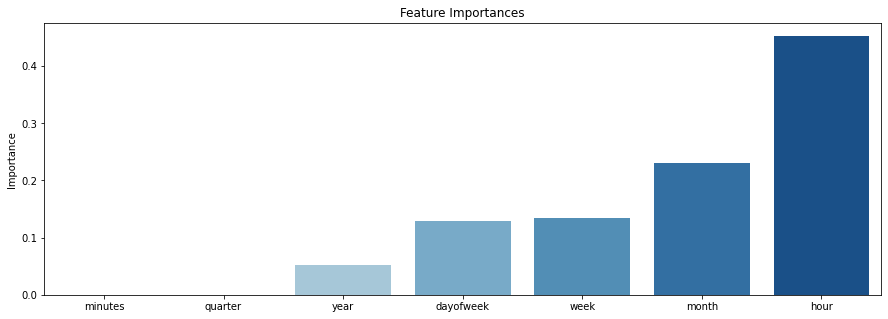

In [25]:
fig, ax = plt.subplots(figsize = (15,5))
sns.barplot(data = fi, x = fi.index, y = 'Importance', palette='Blues')
ax.set_title('Feature Importances')
plt.show()

## Forecast on test set

In [26]:
test['predictions'] = reg.predict(X_test)
test.head()

,PJMW_MW,hour,minutes,dayofweek,month,week,quarter,year,predictions
Datetime,,,,,,,,,
2015-12-31 01:00:00,4530.0,1,0,3,12,53,4,2015,5177.023438
2015-12-31 02:00:00,4383.0,2,0,3,12,53,4,2015,5095.110352
2015-12-31 03:00:00,4299.0,3,0,3,12,53,4,2015,5053.588867
2015-12-31 04:00:00,4338.0,4,0,3,12,53,4,2015,5053.588867
2015-12-31 05:00:00,4427.0,5,0,3,12,53,4,2015,5075.265137


In [27]:
sample = df.merge(test[['predictions']], how = 'left', left_index= True, right_index= True )
sample

,PJMW_MW,hour,minutes,dayofweek,month,week,quarter,year,predictions
Datetime,,,,,,,,,
2002-04-01 01:00:00,4374.0,1,0,0,4,14,2,2002,NaN
2002-04-01 02:00:00,4306.0,2,0,0,4,14,2,2002,NaN
2002-04-01 03:00:00,4322.0,3,0,0,4,14,2,2002,NaN
2002-04-01 04:00:00,4359.0,4,0,0,4,14,2,2002,NaN
2002-04-01 05:00:00,4436.0,5,0,0,4,14,2,2002,NaN
...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,6545.0,20,0,3,8,31,3,2018,6775.489258
2018-08-02 21:00:00,6496.0,21,0,3,8,31,3,2018,6732.177246
2018-08-02 22:00:00,6325.0,22,0,3,8,31,3,2018,6585.650391


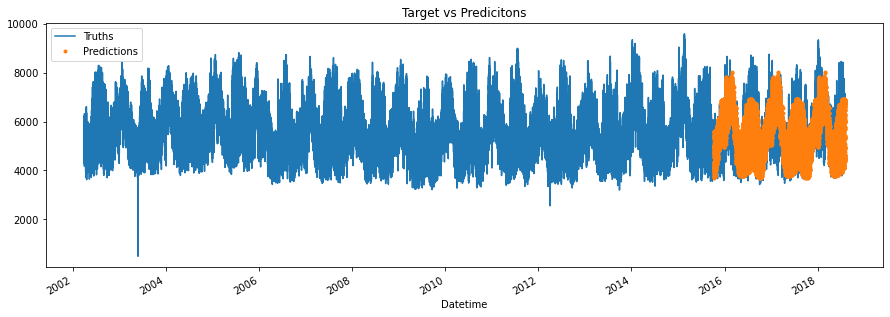

In [28]:
ax = sample[['PJMW_MW']].plot(figsize = (15,5))
sample[['predictions']].plot(ax = ax, style = '.')
plt.legend(['Truths','Predictions'])
ax.set_title('Target vs Predicitons')
plt.show()

In [29]:
import numpy as np
score = np.sqrt(mean_squared_error(test['predictions'],test['PJMW_MW']))
print('RMSE score:{0:0.2f}'.format(score))

RMSE score:728.14


In [31]:
sample.columns

Index(['PJMW_MW', 'hour', 'minutes', 'dayofweek', 'month', 'week', 'quarter',
       'year', 'predictions'],
      dtype='object')

In [32]:
test

,PJMW_MW,hour,minutes,dayofweek,month,week,quarter,year,predictions
Datetime,,,,,,,,,
2015-12-31 01:00:00,4530.0,1,0,3,12,53,4,2015,5177.023438
2015-12-31 02:00:00,4383.0,2,0,3,12,53,4,2015,5095.110352
2015-12-31 03:00:00,4299.0,3,0,3,12,53,4,2015,5053.588867
2015-12-31 04:00:00,4338.0,4,0,3,12,53,4,2015,5053.588867
2015-12-31 05:00:00,4427.0,5,0,3,12,53,4,2015,5075.265137
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,8401.0,20,0,0,1,1,1,2018,6853.550781
2018-01-01 21:00:00,8373.0,21,0,0,1,1,1,2018,6853.550781
2018-01-01 22:00:00,8238.0,22,0,0,1,1,1,2018,6706.566895


In [33]:
test['Error'] = np.abs(test[target] - test['predictions'])
test

: 

: 

# LSTM


In [61]:
import torch
from torch.utils.data import DataLoader, Dataset

In [62]:
df = pd.read_csv('../datasets/hourlyenergydata/PJMW_hourly.csv')
df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [58]:
#df['column'].fillna(df[column].mean(), inplace = True)
df.iloc[0:7,1]

0    5077.0
1    4939.0
2    4885.0
3    4857.0
4    4930.0
5    5126.0
6    5493.0
Name: PJMW_MW, dtype: float64

In [60]:
#df['PJMW_MW'] = df['PJMW_MW'].apply(lambda x:x*x)
#df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,25775929.0
1,2002-12-31 02:00:00,24393721.0
2,2002-12-31 03:00:00,23863225.0
3,2002-12-31 04:00:00,23590449.0
4,2002-12-31 05:00:00,24304900.0


In [29]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143206 entries, 0 to 143205
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  143206 non-null  datetime64[ns]
 1   PJMW_MW   143206 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB


In [30]:
df = df.set_index('Datetime')

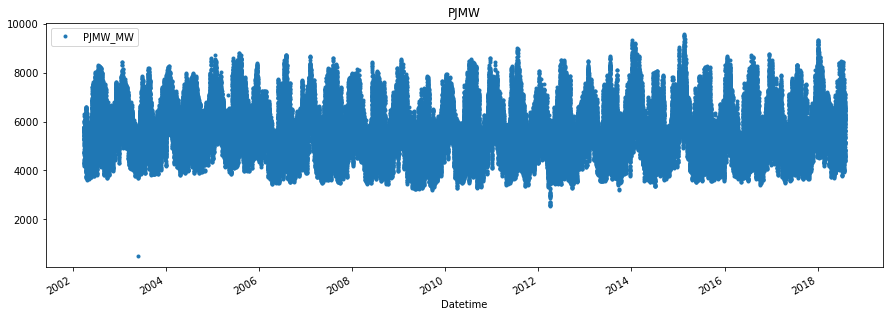

In [31]:
df.plot(style = '.',figsize = (15,5), title = "PJMW")
plt.show()

In [34]:
def createFeatures(df):
    df = df.copy()
    df['hours'] = df.index.hour
    df['day'] = df.index.day_of_week
    df['week'] = df.index.week
    df['months'] = df.index.month
    df['years'] = df.index.year
    return df


In [35]:
df_f = createFeatures(df)
df_f.head()

/tmp/ipykernel_260/4180132021.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = df.index.week


,PJMW_MW,hours,day,week,months,years
Datetime,,,,,,
2002-12-31 01:00:00,5077.0,1,1,1,12,2002
2002-12-31 02:00:00,4939.0,2,1,1,12,2002
2002-12-31 03:00:00,4885.0,3,1,1,12,2002
2002-12-31 04:00:00,4857.0,4,1,1,12,2002
2002-12-31 05:00:00,4930.0,5,1,1,12,2002


In [44]:
len = df.shape[0]*0.8
len

114564.8

In [45]:
train = df_f[:int(len)]
test = df_f[int(len):]


In [50]:
tr = train['PJMW_MW']
te = test['PJMW_MW']


In [52]:
tr_nump = tr.to_numpy()
te_nump = te.to_numpy()